In [1]:
import numpy as np
import gymnasium as gym
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensoraerospace.agent.mpc.stochastic import MPCAgent, Net
from tensoraerospace.agent.mpc.gradient import MPCOptimizationAgent

In [2]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=200, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
#reference_signals = np.reshape(unit_step(degree=1, tp=tp, time_step=5, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=-0.008, tp=tp, frequency=1)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0],[0],[0]],
                reference_signal=reference_signals,
                output_space = ["theta",  "alpha",  "q",],
                state_space = ["theta", "alpha", "q", "ele", ],
                tracking_states=["theta"])

# Сброс среды к начальному состоянию
state, info = env.reset()

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [3]:
from tqdm import tqdm
import numpy as np

In [44]:
def cost(next_state, action, reference_signals, step):
    # Извлечение состояния системы
    theta, omega_z = next_state
    
    # Получение эталонного сигнала на данном шаге
    theta_ref = reference_signals[0][step]
    
    # Расчёт ошибки тангажа
    pitch_error = (theta - theta_ref) ** 2
    
    # Штраф за управление
    control_penalty = abs(action)
    
    # Включение штрафа за быстрое изменение угла (если это применимо)
    omega_penalty = omega_z ** 2
    
    # Взвешивание ошибок и штрафов
    cost = pitch_error + 0.01 * control_penalty + 0.01 * omega_penalty
    
    return cost


In [45]:
control_exploration_signal = np.reshape(unit_step(degree=10, tp=tp, time_step=1, dt=dt, output_rad=True), [1, -1])[0]
control_exploration_signal = np.reshape(np.deg2rad(sinusoid(amplitude=0.008, tp=tp, frequency=25)), [1, -1])[0]

states=[]
costs_list = []
actions=[]
next_states = []
state, info = env.reset()
for _ in tqdm(range(1)):
    state, info = env.reset()
    done = False
    index_exp_signal = 0
    for step in tqdm(range(number_time_steps-2)):
        action = control_exploration_signal[index_exp_signal]
        # action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step([action])
        cost = cost_function(next_state, action, reference_signals, step)
        costs_list.append(cost)
        done = terminated or truncated
        states.append(state)
        actions.append(action)
        next_states.append(next_state)
        state = next_state
        index_exp_signal+=1


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 6612.38it/s] 

[0. 0. 0.]
[-9.92927829e-09 -4.79522706e-08 -1.98318182e-06]
[-4.95391174e-08 -1.61621512e-07 -5.93347000e-06]
[-1.38420356e-07 -3.58526996e-07 -1.18348509e-05]
[-2.96003998e-07 -6.55944457e-07 -1.96713713e-05]
[-5.41561814e-07 -1.07090796e-06 -2.94271374e-05]
[-8.94206929e-07 -1.62021176e-06 -4.10863131e-05]
[-1.37289439e-06 -2.32041212e-06 -5.46331194e-05]
[-1.99642173e-06 -3.18782909e-06 -7.00518327e-05]
[-2.78342952e-06 -4.23854837e-06 -8.73267838e-05]
[-3.75240192e-06 -5.48842298e-06 -1.06442357e-04]
[-4.92166718e-06 -6.95307508e-06 -1.27382988e-04]
[-6.30939816e-06 -8.64789767e-06 -1.50133165e-04]
[-7.93361286e-06 -1.05880563e-05 -1.74677425e-04]
[-9.81217489e-06 -1.27884907e-05 -2.01000353e-04]
[-1.19627940e-05 -1.52639166e-05 -2.29086585e-04]
[-1.44030264e-05 -1.80288272e-05 -2.58920801e-04]
[-1.71502755e-05 -2.10974949e-05 -2.90487727e-04]
[-2.02217921e-05 -2.44839731e-05 -3.23772137e-04]
[-2.36346749e-05 -2.82020973e-05 -3.58758844e-04]
[-2.74058712e-05 -3.22654871e-05 -3.954


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


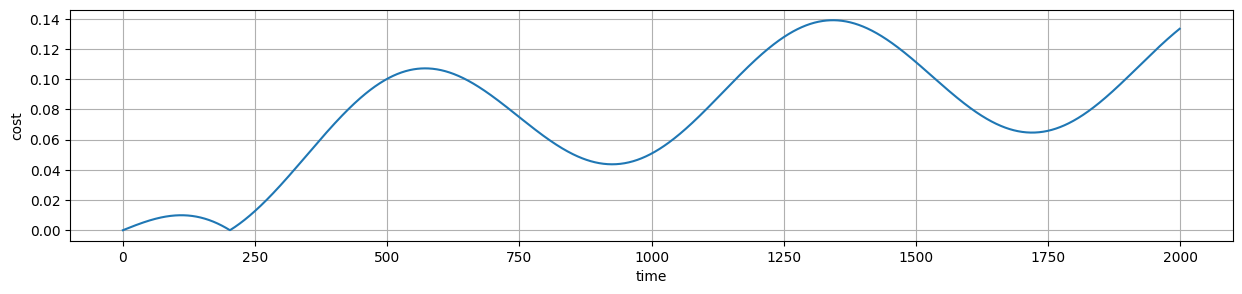

In [46]:
from matplotlib.pyplot import figure

figure(figsize=(15, 3))
plt.xlabel("time")
plt.ylabel("cost")

plt.plot(costs_list)
plt.grid(True)

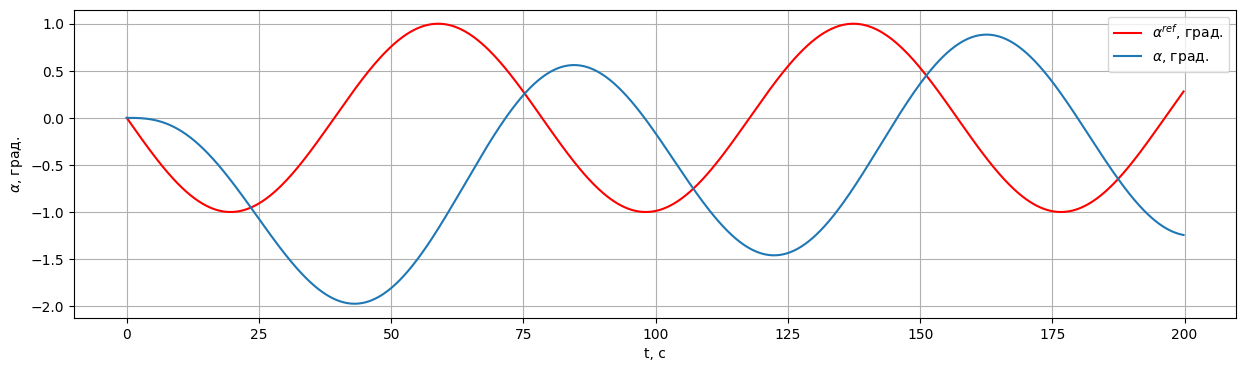

In [47]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], figsize=(15,4), to_deg=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


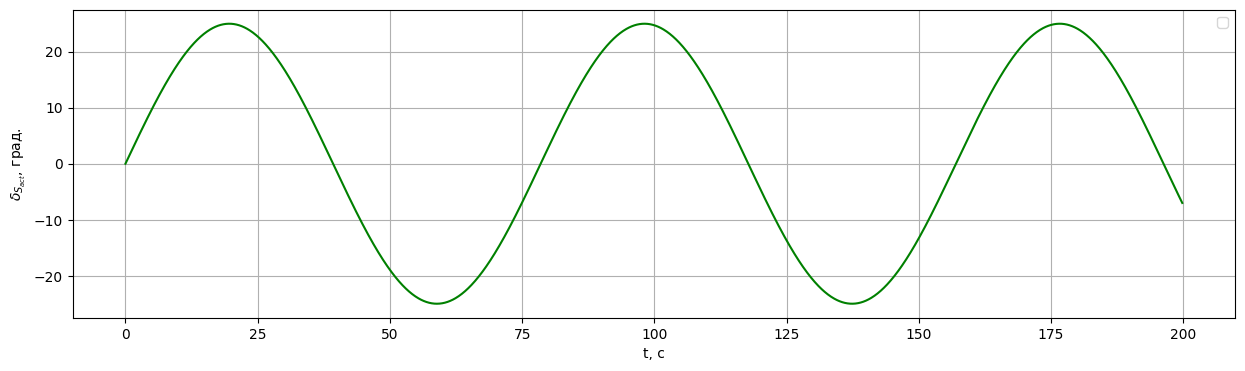

In [13]:
env.unwrapped.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

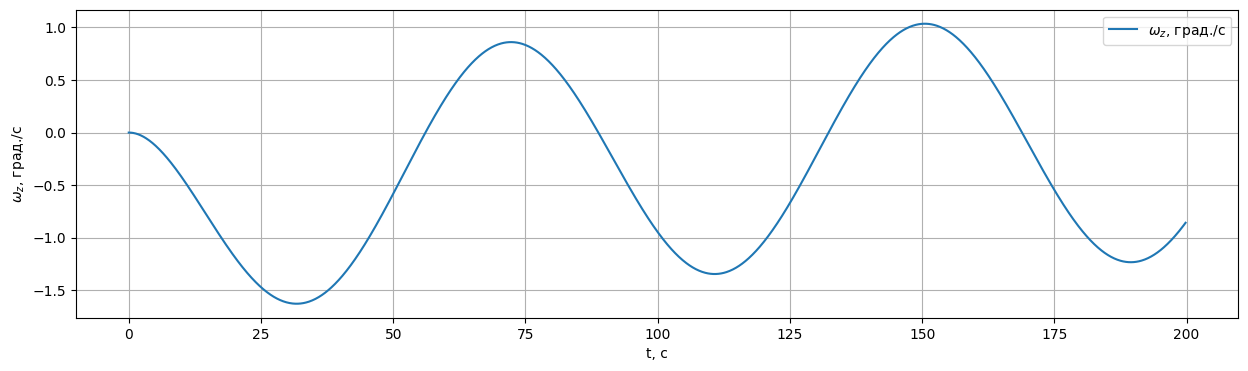

In [14]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

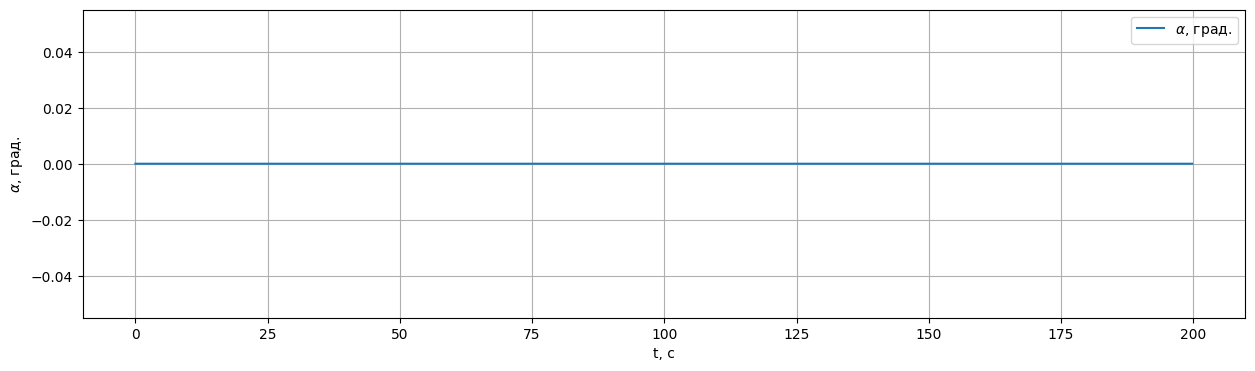

In [18]:
env.unwrapped.model.plot_state('alpha', tps, figsize=(15,4), to_deg=True)

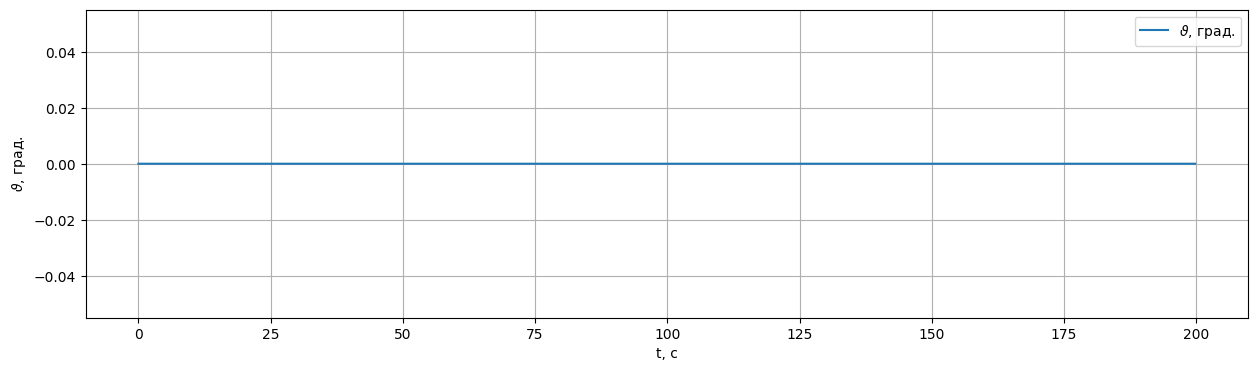

In [19]:
env.unwrapped.model.plot_state('theta', tps, figsize=(15,4), to_deg=True)